In [1]:
# PGD Attack and Defend on AlexNet
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Subset
import random
import torch.optim as optim


num_epochs = 10
#batch_size = 128
learning_rate = 0.001

class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 4 * 4, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Safely flatten the tensor
        x = self.classifier(x)
        return x

# Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Adjust as needed
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Dataset and DataLoader
train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

# Model
model = AlexNet(num_classes=10).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()



In [2]:
# Train Model on clean Dataset
for epoch in range(num_epochs):
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i + 1) % 200 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')


Epoch [1/10], Step [200/938], Loss: 0.7484
Epoch [1/10], Step [400/938], Loss: 0.7690
Epoch [1/10], Step [600/938], Loss: 0.5392
Epoch [1/10], Step [800/938], Loss: 0.4081
Epoch [2/10], Step [200/938], Loss: 0.2727
Epoch [2/10], Step [400/938], Loss: 0.6768
Epoch [2/10], Step [600/938], Loss: 0.4293
Epoch [2/10], Step [800/938], Loss: 0.4268
Epoch [3/10], Step [200/938], Loss: 0.3348
Epoch [3/10], Step [400/938], Loss: 0.4042
Epoch [3/10], Step [600/938], Loss: 0.2325
Epoch [3/10], Step [800/938], Loss: 0.3404
Epoch [4/10], Step [200/938], Loss: 0.2369
Epoch [4/10], Step [400/938], Loss: 0.4988
Epoch [4/10], Step [600/938], Loss: 0.4412
Epoch [4/10], Step [800/938], Loss: 0.3492
Epoch [5/10], Step [200/938], Loss: 0.2695
Epoch [5/10], Step [400/938], Loss: 0.2372
Epoch [5/10], Step [600/938], Loss: 0.2034
Epoch [5/10], Step [800/938], Loss: 0.2715
Epoch [6/10], Step [200/938], Loss: 0.4484
Epoch [6/10], Step [400/938], Loss: 0.4222
Epoch [6/10], Step [600/938], Loss: 0.2125
Epoch [6/10

In [3]:
# Test on clean Dataset
def test_model(data_loader):
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

print(f'Accuracy on the clean test set: {test_model(test_loader):.2f}%')


Accuracy on the clean test set: 90.52%


test acc 21.875%
test acc 20.3125%
test acc 17.1875%
test acc 15.625%
test acc 14.0625%
test acc 10.9375%
test acc 10.9375%
test acc 9.375%
test acc 9.375%
test acc 9.375%


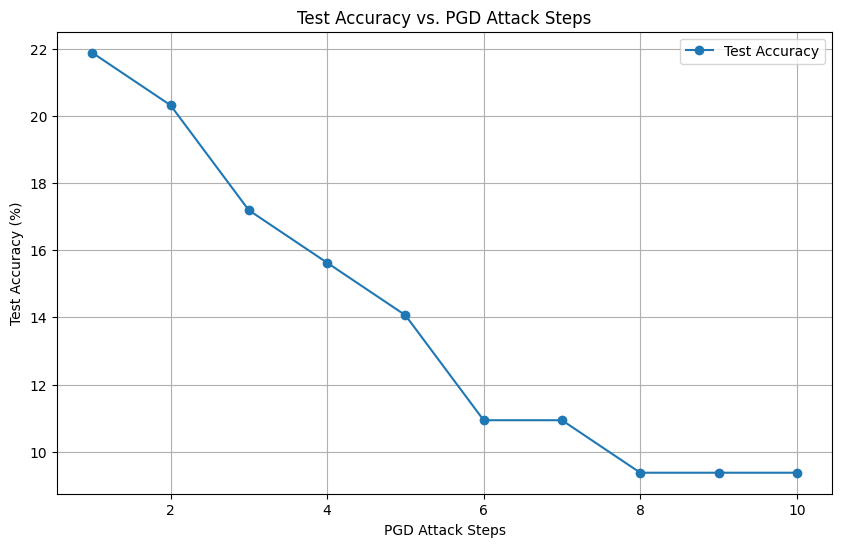

In [4]:
# PGD Attack

import matplotlib.pyplot as plt

def pgd_attack(model, images, labels, eps, alpha, iters):
    adv_images = images.clone().detach()
    original_images = images.clone().detach()
    all_adv_images = []  

    for _ in range(iters):
        adv_images.requires_grad = True
        outputs = model(adv_images)
        loss = nn.CrossEntropyLoss()(outputs, labels)

        model.zero_grad()
        loss.backward()
        adv_images = adv_images + alpha * adv_images.grad.sign()
        eta = torch.clamp(adv_images - original_images, min=-eps, max=eps)
        adv_images = torch.clamp(original_images + eta, min=0, max=1).detach()
        
        all_adv_images.append(adv_images.clone().detach())  

    return adv_images, all_adv_images

eps = 0.03
alpha = 0.007
iters = 10
step_accuracies = []

for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    _, all_adv_images = pgd_attack(model, images, labels, eps, alpha, iters)
    
    for adv_images in all_adv_images:
        acc = test_model([(adv_images, labels)])
        print(f"test acc {acc}%")
        step_accuracies.append(acc)
    break  

plt.figure(figsize=(10, 6))
plt.plot(range(1, iters + 1), step_accuracies, marker='o', label='Test Accuracy')
plt.title('Test Accuracy vs. PGD Attack Steps')
plt.xlabel('PGD Attack Steps')
plt.ylabel('Test Accuracy (%)')
plt.grid()
plt.legend()
plt.show()

In [5]:
# Defend against PGD

for epoch in range(num_epochs):
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        adv_images,_ = pgd_attack(model, images, labels, eps, alpha, iters)

        combined_images = torch.cat([images, adv_images], dim=0)
        combined_labels = torch.cat([labels, labels], dim=0)

        outputs = model(combined_images)
        loss = criterion(outputs, combined_labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i + 1) % 200 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

print(f'Accuracy on the clean test set after adversarial retraining: {test_model(test_loader):.2f}%')
print(f'Accuracy on adversarial examples after adversarial retraining: {test_model([(adv_images, labels)]):.2f}%')


Epoch [1/10], Step [200/938], Loss: 0.4129
Epoch [1/10], Step [400/938], Loss: 0.3274
Epoch [1/10], Step [600/938], Loss: 0.5551
Epoch [1/10], Step [800/938], Loss: 0.4837
Epoch [2/10], Step [200/938], Loss: 0.3929
Epoch [2/10], Step [400/938], Loss: 0.4216
Epoch [2/10], Step [600/938], Loss: 0.4385
Epoch [2/10], Step [800/938], Loss: 0.3887
Epoch [3/10], Step [200/938], Loss: 0.4025
Epoch [3/10], Step [400/938], Loss: 0.2504
Epoch [3/10], Step [600/938], Loss: 0.3618
Epoch [3/10], Step [800/938], Loss: 0.3023
Epoch [4/10], Step [200/938], Loss: 0.3046
Epoch [4/10], Step [400/938], Loss: 0.3778
Epoch [4/10], Step [600/938], Loss: 0.3818
Epoch [4/10], Step [800/938], Loss: 0.5117
Epoch [5/10], Step [200/938], Loss: 0.3027
Epoch [5/10], Step [400/938], Loss: 0.3803
Epoch [5/10], Step [600/938], Loss: 0.3690
Epoch [5/10], Step [800/938], Loss: 0.3896
Epoch [6/10], Step [200/938], Loss: 0.2891
Epoch [6/10], Step [400/938], Loss: 0.4000
Epoch [6/10], Step [600/938], Loss: 0.4068
Epoch [6/10